# Minnesota Potential Scattering RBM Challenge

(adapted from Daniel Odell's BAND Camp ROSE tutorial: https://indico.cern.ch/event/1223721/contributions/5394829/ and from: http://rbm.ascsn.net/scattering/scattering.html)

The purpose of this challenge is for you to build a reduced basis emulator to solve single channel two body scattering :

\begin{equation}
    F_\alpha(\phi)=\left(-\frac{d^2}{dr^2}+\frac{\ell(\ell+1)}{r^2}+U(r,\alpha)-p^2\right)\phi(r)=0,
\end{equation}

where a system with reduced mass $\mu$ interacts through a potential $V(r,\alpha)=U(r,\alpha)/2\mu$ with parameters $\alpha$, $\ell$ is the angular momentum quantum number, and $p$ is the asymptotic linear momentum. 

The potential in this case is:

\begin{equation}
V(r,V_{0R},V_{0S})=2\mu\left(V_{0R}e^{-1.487r^2}+ V_{0S}e^{-0.465r^2}\right),
\end{equation}


where the parameters are $\alpha=[V_{0R},V_{0S}]$. We have kept the non-linear parameter dependence of the potential (the coefficients multiplying $r^2$ on the exponentials) fixed on their original values, but you can try the challenge on the Empirical Interpolation Method to learn how to change those. 

We can re-scale this equation with the changes of variables $s=pr$ (if we were using the empirical interpolation method we could then apply the RBM across energies). We obtain the following equation:

\begin{equation}
    \left(-\frac{d^2}{ds^2}+\frac{\ell(\ell+1)}{s^2}+\tilde U(s,\alpha,p)-1\right)\phi_\alpha(s)=0,
\end{equation}

where the potential $\tilde U(s,\alpha,p)=V(s/p,\alpha)2\mu/p^2$ is now momentum dependent.

You can get inspiration from: http://rbm.ascsn.net/.

Your tasks are:

- Build your reduced basis from the principal components (singular value decomposition) of a handful of high fidelity solutions:

\begin{equation}
    \phi(r) \approx \hat \phi(r) = \phi_0(r)+ \sum_{k=1}^n a_k \phi_k(r),
\end{equation}

Since this problem is homogenous in $\phi$, you will benefit from introducing an independent term $\phi_0(r)$ without any coefficient. One option is to use $\phi_0$ as the free solution and create the $\phi_k(r)$ from the principal components of the differences between $\phi_0$ and the high fidelity solutions ${\rm SVD}(\phi(r) - \phi_0(r))$


We can use python's initial value problem solver, usually some variation of Runge-Kuta, as the high fidelity solver: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html. You can change the relative and absolute tolerances of this high fidelity solver to increase speed at the cost of accuracy.


- Create the reduced equations by projecting the differential equation onto the subspace made by your own reduced basis:

\begin{equation}\label{eqn:projections}
    \begin{aligned}
    &\langle \phi_j|F_\alpha[\hat{\phi}]\rangle= \\
    &\langle \phi_j | F_\alpha|\phi_0 \rangle + \sum_k ^{n} a_k\langle \phi_j | F_\alpha|\phi_k \rangle =0
    \quad \text{for }j\in [1,n],
    \end{aligned}
\end{equation}

You can use dot products in python as a way to calculate integrals between lists (vectors) representing functions. Once the integrals are done you can write the previous equation in matrix form for the coefficients $a_1,a_2,...a_n$.

- Create a Computational Accuracy vs Time plot to compare the performance of the reduced basis approximation with the high fidelity solver. You can change the total number of basis $n$ for the reduced basis approach and tolerance for the high fidelity solver.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import diags


In [3]:
#Example of constants and high fidelity solver

hbarc = 197 # MeV • fm
mass = 939 # MeV
energy = 50 # center-of-mass scattering energy, fixed for the first example
k = np.sqrt(mass*energy)/hbarc
l = 0 # S waves

# interaction parameters we will use for testing
v0r = 200
v0s = -91.85

def mn_potential(r, args):
    '''
    Minnesota potential
    '''
    v_0r, v_0s = args
    return v_0r * np.exp(-1.487*r**2) + v_0s*np.exp(-0.465*r**2)


def mn_potential_tilde(s, args):
    '''
    Energy-scaled Minnesota potential
    s = rho = kr
    '''
    return 1/energy * mn_potential(s/k, args)


In [4]:
initial_conditions = np.array([0.0, 1.0]) # initial phi(0) and phi'(0) conditions
s_endpts = k * np.array([1e-6, 20]) # dimensionless

ns = 2000
s_mesh = np.linspace(*s_endpts, ns)


def solve_se(theta):
    result = solve_ivp(
        lambda s, phi: np.array([phi[1],
            (mn_potential_tilde(s, theta) + l*(l+1)/s**2 - 1.0) * phi[0]]),
        [1e-12, s_endpts[1]], initial_conditions, rtol=1e-12, atol=1e-12, dense_output=True
    )
    phi = result.sol(s_mesh)[0, :]

    return s_mesh, phi

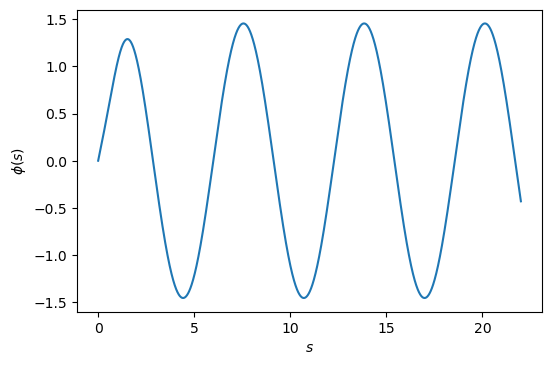

In [5]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')


ax.plot(s_mesh, solve_se([v0r,v0s])[1])

ax.set_ylabel(r'$\phi(s)$')
ax.set_xlabel(r'$s$');

In [ ]:
#Rest of the smart code goes here...